# Домашнее задание: Логистическая регрессия с градиентным спуском
## Цель: Реализовать логистическую регрессию с нуля без использования готовых решений из sklearn

## 1. Импорт библиотек

In [1]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

In [2]:
# Настройка стилей графиков
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

## 2. Загрузка и подготовка данных

In [3]:

# Загрузка датасета Iris
iris = load_iris()
X = iris.data
y = iris.target
feature_names = iris.feature_names
target_names = iris.target_names

# Создаем DataFrame для анализа
df = pd.DataFrame(X, columns=feature_names)
df['target'] = y
df['target_name'] = [target_names[t] for t in y]

print("Первые 5 строк данных:")
display(df.head())

print(f"\nРазмерность данных: {df.shape}")
print(f"Названия признаков: {feature_names}")
print(f"Названия классов: {target_names}")

Первые 5 строк данных:


,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target,target_name
0,5.1,3.5,1.4,0.2,0,setosa
1,4.9,3.0,1.4,0.2,0,setosa
2,4.7,3.2,1.3,0.2,0,setosa
3,4.6,3.1,1.5,0.2,0,setosa
4,5.0,3.6,1.4,0.2,0,setosa



Размерность данных: (150, 6)
Названия признаков: ['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']
Названия классов: ['setosa' 'versicolor' 'virginica']


Распределение классов после фильтрации:
target_name
versicolor    50
virginica     50
Name: count, dtype: int64


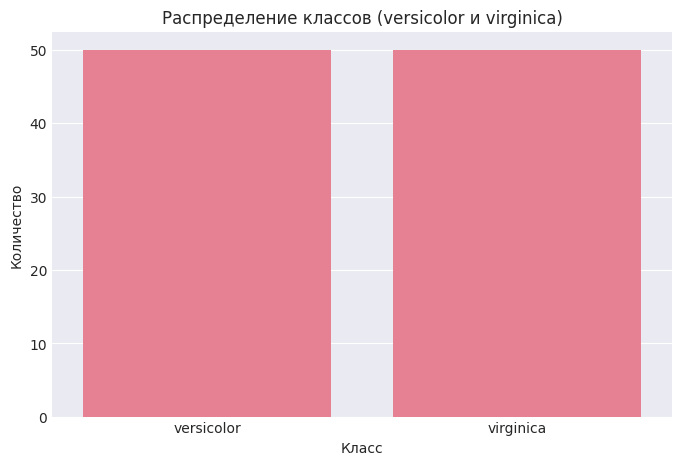

In [4]:

# Оставляем только классы 1 и 2 (versicolor и virginica)
df_filtered = df[df['target'].isin([1, 2])].copy()

# Преобразуем метки: versicolor -> 0, virginica -> 1
df_filtered['target'] = df_filtered['target'] - 1

print("Распределение классов после фильтрации:")
print(df_filtered['target_name'].value_counts())

# Визуализация распределения классов
plt.figure(figsize=(8, 5))
sns.countplot(x='target_name', data=df_filtered)
plt.title('Распределение классов (versicolor и virginica)')
plt.xlabel('Класс')
plt.ylabel('Количество')
plt.show()



<Figure size 1200x800 with 0 Axes>

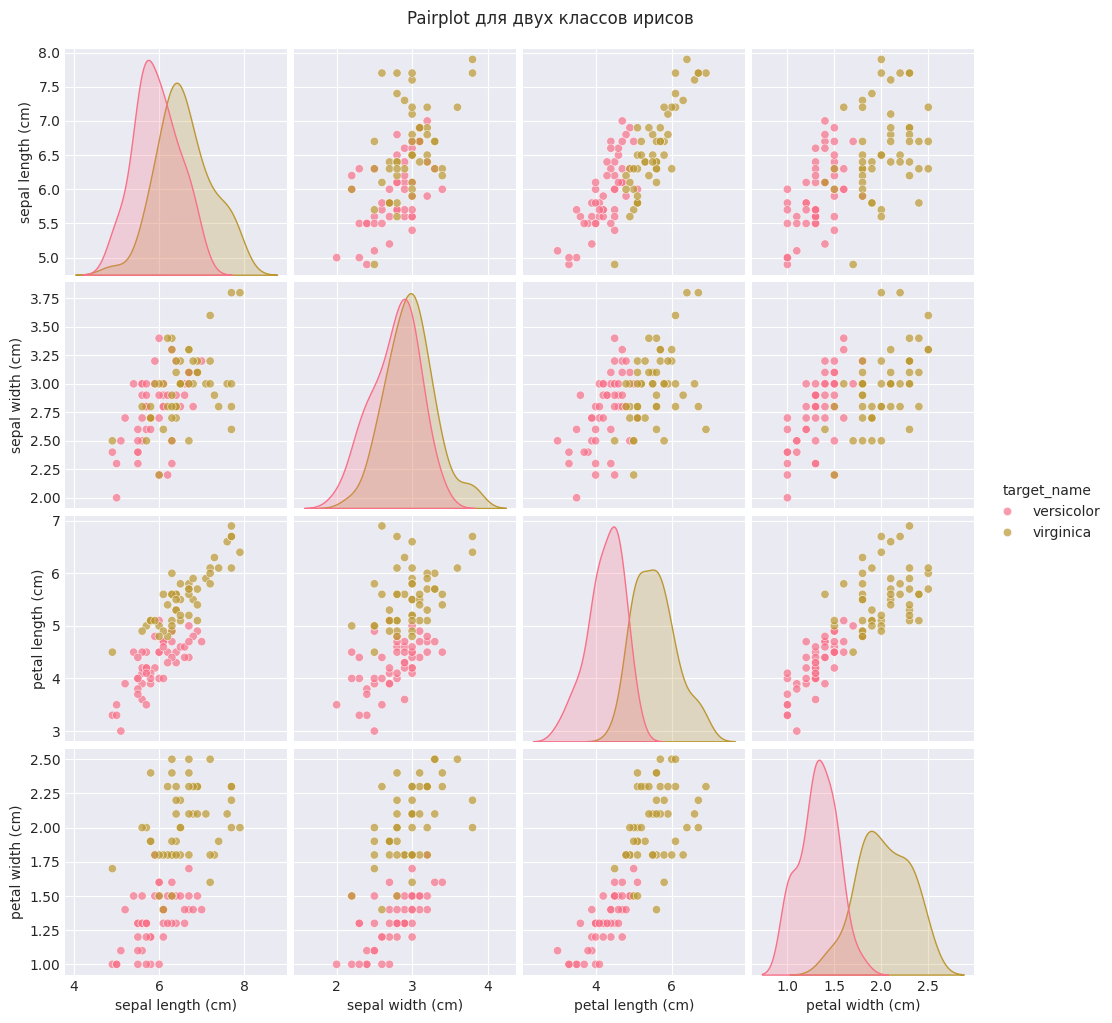

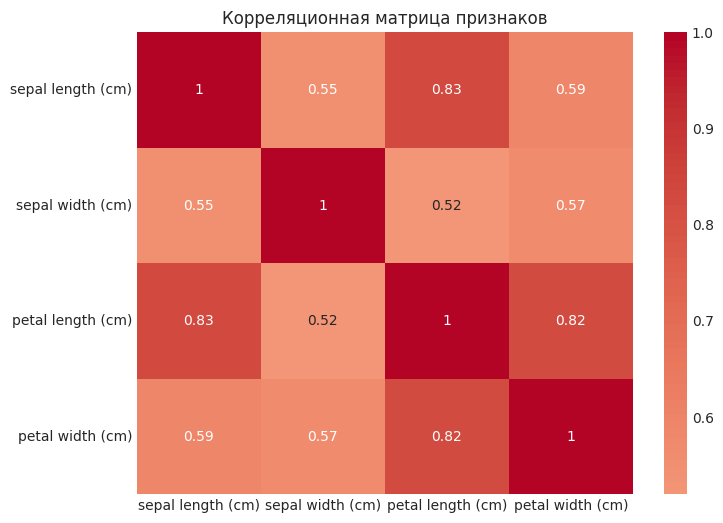

In [5]:
# Визуализация парных зависимостей
plt.figure(figsize=(12, 8))
sns.pairplot(df_filtered, hue='target_name', 
             vars=feature_names, 
             diag_kind='kde',
             plot_kws={'alpha': 0.7})
plt.suptitle('Pairplot для двух классов ирисов', y=1.02)
plt.show()

# Визуализация корреляционной матрицы
plt.figure(figsize=(8, 6))
corr_matrix = df_filtered[feature_names].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Корреляционная матрица признаков')
plt.show()

In [6]:
# Подготовка данных для модели
X_filtered = df_filtered[feature_names].values
y_filtered = df_filtered['target'].values

# Разделение на train и test
X_train, X_test, y_train, y_test = train_test_split(
    X_filtered, y_filtered, 
    test_size=0.2, 
    random_state=42, 
    stratify=y_filtered
)

print(f"Размерность тренировочных данных: {X_train.shape}")
print(f"Размерность тестовых данных: {X_test.shape}")
print(f"\nРаспределение классов в тренировочных данных:")
print(pd.Series(y_train).value_counts())
print(f"\nРаспределение классов в тестовых данных:")
print(pd.Series(y_test).value_counts())



Размерность тренировочных данных: (80, 4)
Размерность тестовых данных: (20, 4)

Распределение классов в тренировочных данных:
0    40
1    40
Name: count, dtype: int64

Распределение классов в тестовых данных:
1    10
0    10
Name: count, dtype: int64


In [7]:
# Нормализация для лучшей сходимости градиентного спуска
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Статистики до нормализации (первые 5 признаков):")
print(f"Среднее: {X_train.mean(axis=0)[:5]}")
print(f"Стандартное отклонение: {X_train.std(axis=0)[:5]}")

print("\nСтатистики после нормализации (первые 5 признаков):")
print(f"Среднее: {X_train_scaled.mean(axis=0)[:5]}")
print(f"Стандартное отклонение: {X_train_scaled.std(axis=0)[:5]}")



Статистики до нормализации (первые 5 признаков):
Среднее: [6.3325 2.9175 4.94   1.7025]
Стандартное отклонение: [0.64319029 0.31255999 0.81418671 0.43902591]

Статистики после нормализации (первые 5 признаков):
Среднее: [-2.05668815e-15 -1.47937218e-15 -4.85722573e-16 -3.33066907e-16]
Стандартное отклонение: [1. 1. 1. 1.]


## 3. Реализация логистической регрессии с градиентным спуском

In [8]:

class LogisticRegressionGD:
    """
    Класс для реализации логистической регрессии с градиентным спуском
    """
    
    def __init__(self, learning_rate=0.01, n_iter=1000, tol=1e-4, 
                 regularization=None, lambda_reg=0.01, random_state=42):
        """
        Инициализация параметров модели
        """
        self.learning_rate = learning_rate
        self.n_iter = n_iter
        self.tol = tol
        self.regularization = regularization  # 'l1', 'l2' или None
        self.lambda_reg = lambda_reg
        self.random_state = random_state
        self.weights = None
        self.bias = None
        self.losses = []
        self.train_accuracies = []
        
    def _sigmoid(self, z):
        """
        Сигмоидная функция активации
        """
        # Для избежания переполнения
        z = np.clip(z, -500, 500)
        return 1 / (1 + np.exp(-z))
    
    def _initialize_parameters(self, n_features):
        """
        Инициализация весов и смещения
        """
        np.random.seed(self.random_state)
        self.weights = np.random.randn(n_features) * 0.01
        self.bias = 0
        
    def _compute_loss(self, y_true, y_pred, X=None):
        """
        Вычисление функции потерь с возможностью регуляризации
        """
        epsilon = 1e-15
        y_pred = np.clip(y_pred, epsilon, 1 - epsilon)
        
        # Основная часть функции потерь (бинарная кросс-энтропия)
        loss = -np.mean(y_true * np.log(y_pred) + (1 - y_true) * np.log(1 - y_pred))
        
        # Добавление регуляризации
        if self.regularization == 'l1':
            loss += self.lambda_reg * np.sum(np.abs(self.weights))
        elif self.regularization == 'l2':
            loss += self.lambda_reg * np.sum(self.weights ** 2) / 2
        
        return loss
    
    def _compute_gradients(self, X, y_true, y_pred):
        """
        Вычисление градиентов с учетом регуляризации
        """
        m = X.shape[0]
        error = y_pred - y_true
        
        # Основные градиенты
        dw = (1 / m) * np.dot(X.T, error)
        db = (1 / m) * np.sum(error)
        
        # Добавление регуляризации к градиентам
        if self.regularization == 'l1':
            dw += self.lambda_reg * np.sign(self.weights)
        elif self.regularization == 'l2':
            dw += self.lambda_reg * self.weights
        
        return dw, db
    
    def fit(self, X, y, X_val=None, y_val=None):
        """
        Обучение модели с градиентным спуском
        """
        n_samples, n_features = X.shape
        self._initialize_parameters(n_features)
        
        y = np.array(y)
        
        print(f"Начинаем обучение модели...")
        print(f"Размерность данных: {X.shape}")
        print(f"Параметры: learning_rate={self.learning_rate}, n_iter={self.n_iter}")
        
        for i in range(self.n_iter):
            # Прямое распространение
            linear_output = np.dot(X, self.weights) + self.bias
            y_pred = self._sigmoid(linear_output)
            
            # Вычисление потерь
            loss = self._compute_loss(y, y_pred, X)
            self.losses.append(loss)
            
            # Вычисление accuracy на тренировочных данных
            train_acc = self._compute_accuracy(X, y)
            self.train_accuracies.append(train_acc)
            
            # Вычисление градиентов
            dw, db = self._compute_gradients(X, y, y_pred)
            
            # Обновление параметров
            self.weights -= self.learning_rate * dw
            self.bias -= self.learning_rate * db
            
            # Проверка критерия остановки
            if i > 0 and abs(self.losses[-1] - self.losses[-2]) < self.tol:
                print(f"Ранняя остановка на итерации {i}")
                break
            
        print(f"Обучение завершено. Финальная loss: {self.losses[-1]:.6f}")
        
    def _compute_accuracy(self, X, y_true):
        """
        Вычисление accuracy
        """
        y_pred = self.predict(X)
        return accuracy_score(y_true, y_pred)
    
    def predict_proba(self, X):
        """
        Предсказание вероятностей
        """
        linear_output = np.dot(X, self.weights) + self.bias
        return self._sigmoid(linear_output)
    
    def predict(self, X, threshold=0.5):
        """
        Предсказание классов
        """
        probabilities = self.predict_proba(X)
        return (probabilities >= threshold).astype(int)
    
    def score(self, X, y):
        """
        Accuracy метрика
        """
        y_pred = self.predict(X)
        return accuracy_score(y, y_pred)

Начинаем обучение модели...
Размерность данных: (80, 4)
Параметры: learning_rate=0.1, n_iter=1000
Ранняя остановка на итерации 902
Обучение завершено. Финальная loss: 0.151579


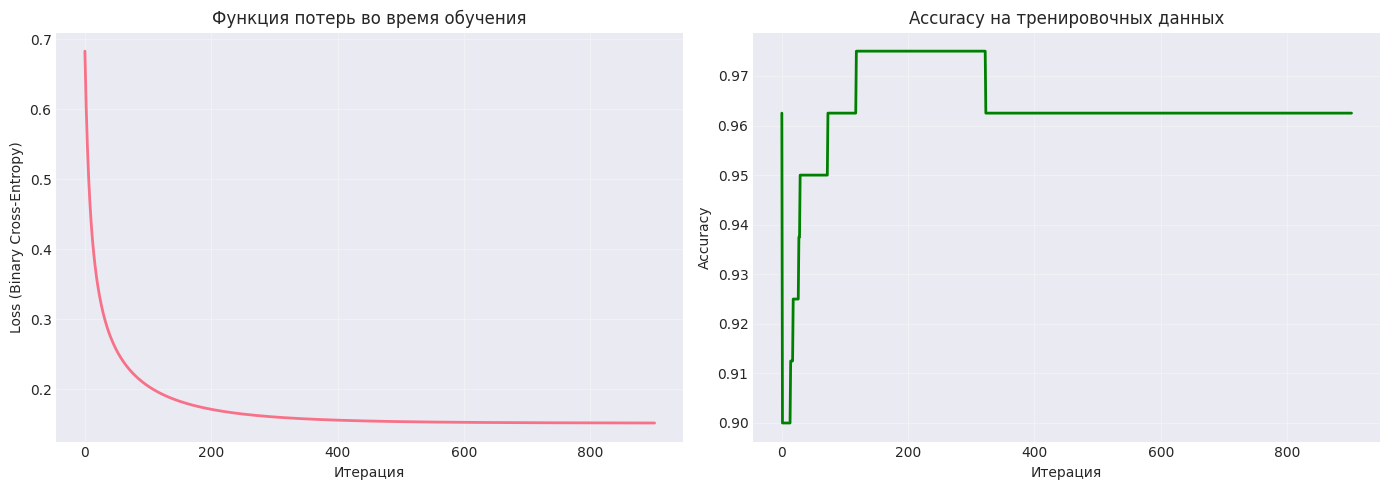

In [9]:
# Создаем и обучаем модель
model = LogisticRegressionGD(
    learning_rate=0.1,
    n_iter=1000,
    tol=1e-6,
    regularization='l2',  # L2 регуляризация для предотвращения переобучения
    lambda_reg=0.01,
    random_state=42
)

# Обучение модели
model.fit(X_train_scaled, y_train)

#Визуализация процесса обучения

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# График функции потерь
axes[0].plot(model.losses, linewidth=2)
axes[0].set_title('Функция потерь во время обучения')
axes[0].set_xlabel('Итерация')
axes[0].set_ylabel('Loss (Binary Cross-Entropy)')
axes[0].grid(True, alpha=0.3)

# График accuracy
axes[1].plot(model.train_accuracies, linewidth=2, color='green')
axes[1].set_title('Accuracy на тренировочных данных')
axes[1].set_xlabel('Итерация')
axes[1].set_ylabel('Accuracy')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 4. Оценка качества модели

РЕЗУЛЬТАТЫ ОЦЕНКИ МОДЕЛИ
Accuracy на тренировочных данных: 0.9625
Accuracy на тестовых данных: 0.9000

ОТЧЕТ О КЛАССИФИКАЦИИ (Test Data)
              precision    recall  f1-score   support

  versicolor       0.90      0.90      0.90        10
   virginica       0.90      0.90      0.90        10

    accuracy                           0.90        20
   macro avg       0.90      0.90      0.90        20
weighted avg       0.90      0.90      0.90        20



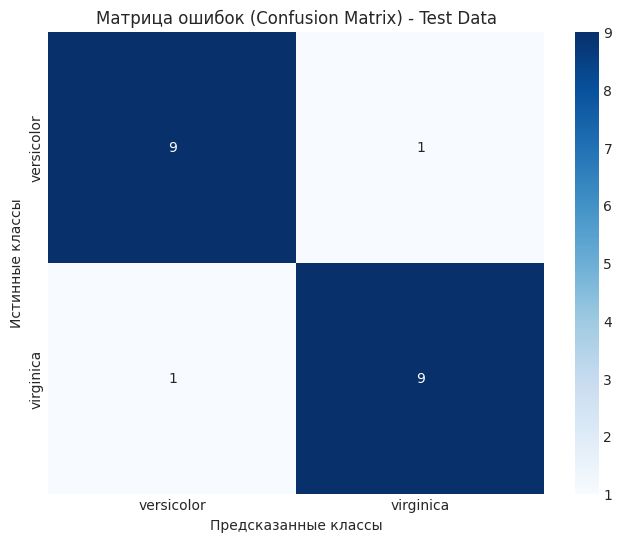

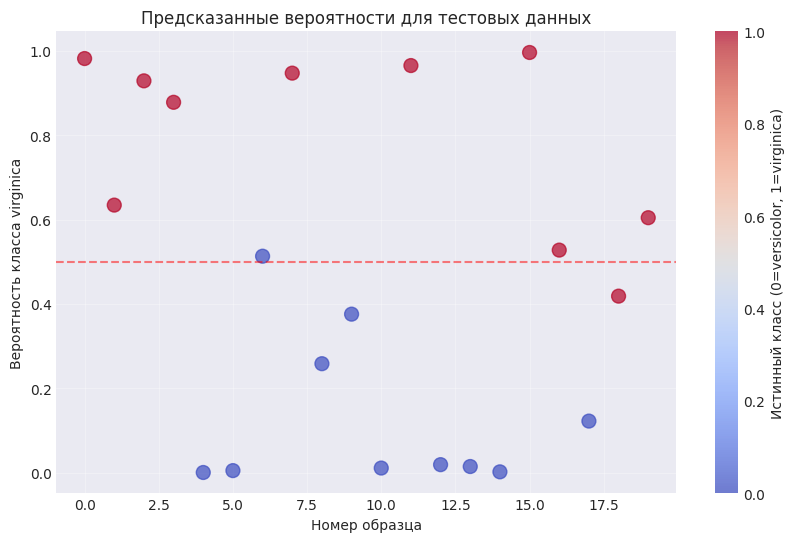

In [10]:

# Предсказания на тренировочных и тестовых данных
y_train_pred = model.predict(X_train_scaled)
y_test_pred = model.predict(X_test_scaled)

# Вычисление accuracy
train_accuracy = model.score(X_train_scaled, y_train)
test_accuracy = model.score(X_test_scaled, y_test)

print("=" * 60)
print("РЕЗУЛЬТАТЫ ОЦЕНКИ МОДЕЛИ")
print("=" * 60)
print(f"Accuracy на тренировочных данных: {train_accuracy:.4f}")
print(f"Accuracy на тестовых данных: {test_accuracy:.4f}")

# Вывод отчета о классификации
print("\n" + "=" * 60)
print("ОТЧЕТ О КЛАССИФИКАЦИИ (Test Data)")
print("=" * 60)
print(classification_report(y_test, y_test_pred, 
                          target_names=['versicolor', 'virginica']))


# Матрица ошибок
cm = confusion_matrix(y_test, y_test_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['versicolor', 'virginica'],
            yticklabels=['versicolor', 'virginica'])
plt.title('Матрица ошибок (Confusion Matrix) - Test Data')
plt.ylabel('Истинные классы')
plt.xlabel('Предсказанные классы')
plt.show()

# Предсказание вероятностей для тестовых данных
y_test_proba = model.predict_proba(X_test_scaled)

plt.figure(figsize=(10, 6))
plt.scatter(range(len(y_test)), y_test_proba, 
            c=y_test, cmap='coolwarm', alpha=0.7, s=100)
plt.axhline(y=0.5, color='red', linestyle='--', alpha=0.5)
plt.title('Предсказанные вероятности для тестовых данных')
plt.xlabel('Номер образца')
plt.ylabel('Вероятность класса virginica')
plt.colorbar(label='Истинный класс (0=versicolor, 1=virginica)')
plt.grid(True, alpha=0.3)
plt.show()

## 5. Анализ модели

АНАЛИЗ ПАРАМЕТРОВ МОДЕЛИ

Веса модели (коэффициенты):
  sepal length (cm)   :     0.0129
  sepal width (cm)    :    -0.4064
  petal length (cm)   :     1.9022
  petal width (cm)    :     2.5047

Смещение (bias): 0.2001

Важность признаков (по абсолютному значению весов):
  1. petal width (cm)    : 2.5047
  2. petal length (cm)   : 1.9022
  3. sepal width (cm)    : 0.4064
  4. sepal length (cm)   : 0.0129


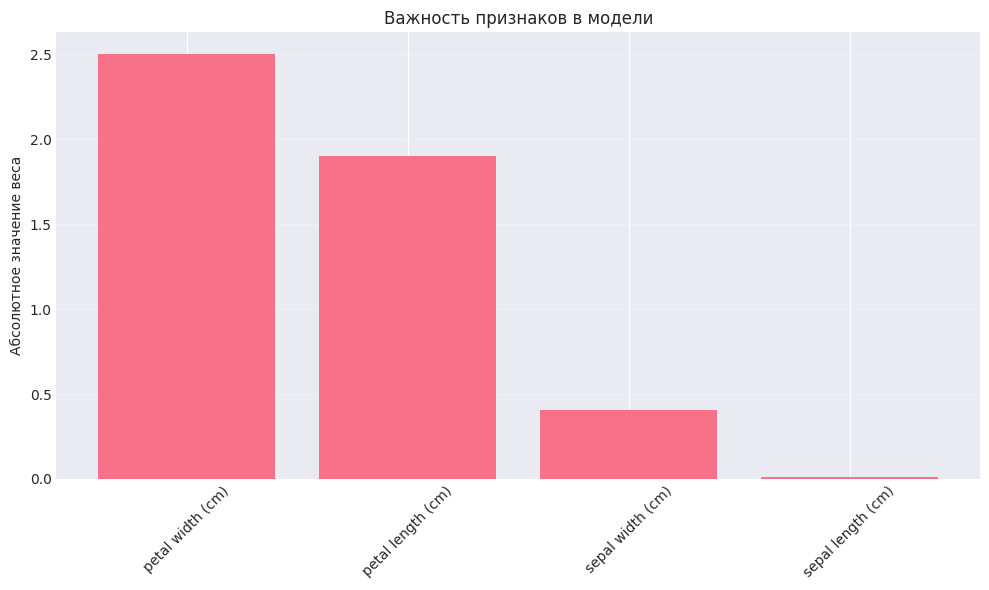

ПРОВЕРКА НА ПЕРЕОБУЧЕНИЕ
Разница между train и test accuracy: 0.0625
⚠️  Умеренная разница, стоит обратить внимание


In [11]:

print("=" * 60)
print("АНАЛИЗ ПАРАМЕТРОВ МОДЕЛИ")
print("=" * 60)

# Веса модели
print("\nВеса модели (коэффициенты):")
for i, (weight, feature_name) in enumerate(zip(model.weights, feature_names)):
    print(f"  {feature_name:20s}: {weight:10.4f}")

print(f"\nСмещение (bias): {model.bias:.4f}")

# Важность признаков
feature_importance = np.abs(model.weights)
sorted_idx = np.argsort(feature_importance)[::-1]

print("\nВажность признаков (по абсолютному значению весов):")
for i, idx in enumerate(sorted_idx):
    print(f"  {i+1}. {feature_names[idx]:20s}: {feature_importance[idx]:.4f}")

# Визуализация важности признаков
plt.figure(figsize=(10, 6))
plt.bar(range(len(feature_names)), feature_importance[sorted_idx])
plt.xticks(range(len(feature_names)), 
           [feature_names[i] for i in sorted_idx], rotation=45)
plt.title('Важность признаков в модели')
plt.ylabel('Абсолютное значение веса')
plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

# Проверка на переобучение
print("=" * 60)
print("ПРОВЕРКА НА ПЕРЕОБУЧЕНИЕ")
print("=" * 60)

difference = train_accuracy - test_accuracy
print(f"Разница между train и test accuracy: {difference:.4f}")

if difference > 0.1:
    print("⚠️  Внимание: Возможно переобучение (большая разница > 0.1)")
elif difference > 0.05:
    print("⚠️  Умеренная разница, стоит обратить внимание")
else:
    print("✓ Разница приемлемая, переобучение маловероятно")

## 6. Эксперименты с гиперпараметрами

Начинаем обучение модели...
Размерность данных: (80, 4)
Параметры: learning_rate=0.001, n_iter=500
Обучение завершено. Финальная loss: 0.525097
Начинаем обучение модели...
Размерность данных: (80, 4)
Параметры: learning_rate=0.01, n_iter=500
Обучение завершено. Финальная loss: 0.244313
Начинаем обучение модели...
Размерность данных: (80, 4)
Параметры: learning_rate=0.1, n_iter=500
Обучение завершено. Финальная loss: 0.090019
Начинаем обучение модели...
Размерность данных: (80, 4)
Параметры: learning_rate=0.5, n_iter=500
Обучение завершено. Финальная loss: 0.059389
Результаты для разных learning rates:


,learning_rate,test_accuracy,final_loss
0,0.001,0.70,0.525097
1,0.010,0.85,0.244313
2,0.100,0.85,0.090019
3,0.500,0.95,0.059389


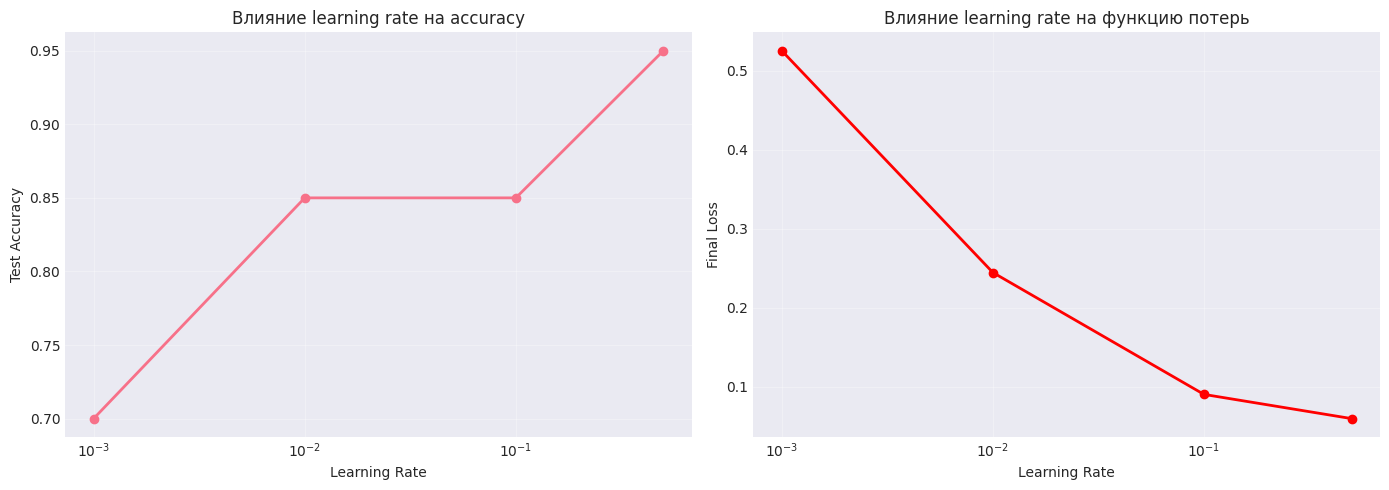

In [12]:

#Влияние learning rate
learning_rates = [0.001, 0.01, 0.1, 0.5]
results_lr = []

for lr in learning_rates:
    temp_model = LogisticRegressionGD(
        learning_rate=lr,
        n_iter=500,
        tol=1e-6,
        random_state=42
    )
    temp_model.fit(X_train_scaled, y_train)
    test_acc = temp_model.score(X_test_scaled, y_test)
    results_lr.append({
        'learning_rate': lr,
        'test_accuracy': test_acc,
        'final_loss': temp_model.losses[-1]
    })

# Создаем DataFrame с результатами
results_df = pd.DataFrame(results_lr)
print("Результаты для разных learning rates:")
display(results_df)

# Визуализация
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].plot(results_df['learning_rate'], results_df['test_accuracy'], 
             marker='o', linewidth=2)
axes[0].set_title('Влияние learning rate на accuracy')
axes[0].set_xlabel('Learning Rate')
axes[0].set_ylabel('Test Accuracy')
axes[0].set_xscale('log')
axes[0].grid(True, alpha=0.3)

axes[1].plot(results_df['learning_rate'], results_df['final_loss'], 
             marker='o', linewidth=2, color='red')
axes[1].set_title('Влияние learning rate на функцию потерь')
axes[1].set_xlabel('Learning Rate')
axes[1].set_ylabel('Final Loss')
axes[1].set_xscale('log')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 7. Заключение и выводы

In [14]:

print("=" * 60)
print("ЗАКЛЮЧЕНИЕ И ВЫВОДЫ")
print("=" * 60)

print(f"\nФинальные результаты:")
print(f"1. Точность модели на тестовых данных: {test_accuracy:.2%}")
print(f"2. Лучший learning rate: {results_df.loc[results_df['test_accuracy'].idxmax(), 'learning_rate']}")
print(f"3. Важнейший признак: {feature_names[sorted_idx[0]]}")
print(f"4. Разница train/test accuracy: {difference:.4f}")

print("\nРекомендации по улучшению модели:")
print("1. Экспериментировать с другими learning rates")
print("2. Добавить регуляризацию для борьбы с переобучением")
print("3. Использовать более сложные методы оптимизации (Adam, RMSprop)")
print("4. Попробовать полиномиальные признаки")
print("5. Использовать кросс-валидацию для подбора гиперпараметров")



ЗАКЛЮЧЕНИЕ И ВЫВОДЫ

Финальные результаты:
1. Точность модели на тестовых данных: 90.00%
2. Лучший learning rate: 0.5
3. Важнейший признак: petal width (cm)
4. Разница train/test accuracy: 0.0625

Рекомендации по улучшению модели:
1. Экспериментировать с другими learning rates
2. Добавить регуляризацию для борьбы с переобучением
3. Использовать более сложные методы оптимизации (Adam, RMSprop)
4. Попробовать полиномиальные признаки
5. Использовать кросс-валидацию для подбора гиперпараметров
